In [1]:
import numpy as np, pandas as pd
import matplotlib.pyplot as plt, seaborn as sns
import scipy
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from sklearn.preprocessing import StandardScaler
import warnings
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import datetime
warnings.filterwarnings('ignore')

In [2]:
#!pip install pmdarima

# Part1. Data Cleaning

In [3]:
#import the data
df = pd.read_csv('Covid19-vaccination.csv')
print('Shape of data',df.shape)

#see the first five of our dataframe
df.head()

Shape of data (63006, 16)


,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
0,Afghanistan,AFG,2021-02-22,0.0,0.0,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN
1,Afghanistan,AFG,2021-02-23,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
2,Afghanistan,AFG,2021-02-24,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
3,Afghanistan,AFG,2021-02-25,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003
4,Afghanistan,AFG,2021-02-26,NaN,NaN,NaN,NaN,NaN,1367.0,NaN,NaN,NaN,NaN,34.0,1367.0,0.003


In [4]:
#check the features with nan values
df.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                     27277
people_vaccinated                      28883
people_fully_vaccinated                31853
total_boosters                         56393
daily_vaccinations_raw                 33083
daily_vaccinations                       326
total_vaccinations_per_hundred         27277
people_vaccinated_per_hundred          28883
people_fully_vaccinated_per_hundred    31853
total_boosters_per_hundred             56393
daily_vaccinations_per_million           326
daily_people_vaccinated                 1558
daily_people_vaccinated_per_hundred     1558
dtype: int64

We've observed some heavy missing data. As we mainly use the total_vaccinations as primary data for our time-series analysis, we will drop total_vaccinations missing data. Otherwise, without this value any raw doesn't make much sense.    

Previoulsy we have 63006 samples in total, but now we have 35729 samples left.

In [5]:
# drop total_vaccinations missing data
df = df.drop(df[df.total_vaccinations.isna()].index)
print(df.shape)
df.isna().sum()

(35729, 16)


location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1879
people_fully_vaccinated                 4751
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1879
people_fully_vaccinated_per_hundred     4751
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

**Then we start to fill the missing values:** 
- **1.1** first by examining the correlation matrix between the features
- **1.2** then perform statistical test on each pair of features which has high correlation
- **1.3** decide how to fill the missing data and make further adjustments

Because if any highly correlated pair of features can be justified by the statistical test, then the missing values within one feature can be derived from the other feature.

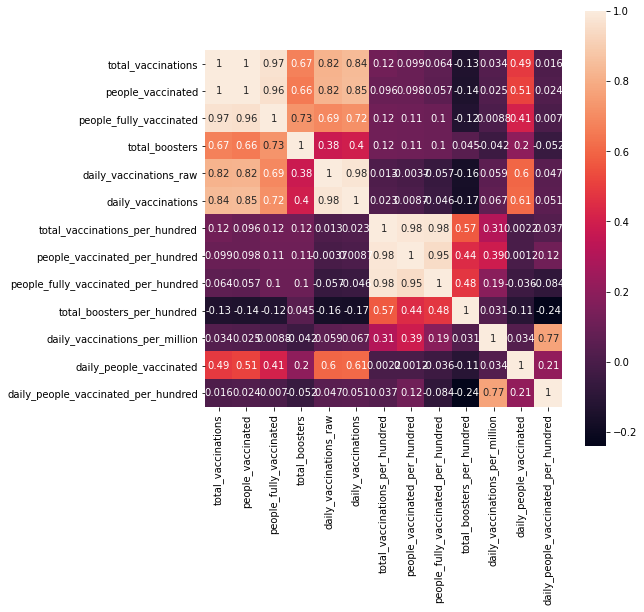

In [6]:
#1.1 examine the correlation matrix between the features
plt.subplots(figsize=(8, 8))
sns.heatmap(df.corr(), annot=True, square=True)
plt.show()

### 1.1 Correlation Matrix   
After examining the correlation matrix, we decide to later check the pairs of features with relatively high correlation $\geq$ 0.95, the ones with cream-white boxes. They have almost ideal correlation. Other features related to dark-color boxes, indicating low correlation, will be filled with 0 for missing values at last in **1.3**.

The pairs of features with high correlation are necessary to do statistical test:
- total_vaccinations and people_vaccinated
- total_vaccinations and people_fully_vaccinated
- total_vaccinations_per_hundred and people_vaccinated_per_hundred
- total_vaccinations_per_hundred and people_fully_vaccinated_per_hundred
- daily vaccinations and daily_vaccinations_raw (disregard, reason shown below)

Notcie that:   
- we mainly use the feature with less missing data as the reference in each pair.
- Last pair listed above would not be tested because the data source website strongly recommends that any analysis on daily vaccination rates be conducted using daily_vaccinations instead of daily_vaccinations_raw. Also, daily_vaccinations has been processed and cannot infer the raw data; thus both features' missing data will be filled with 0.

### 1.2 Statistical Test    
Here we choose the Mann–Whitney U test, a non-parametric statistical test, can be used to decide if there's a difference between the distribution of two independent groups.
- **Null hypothesis**: The two populations represented by the two samples have the same distribution.
- **Alternative hypothesis**: The population distributions are different in some way, center, spread and/or shape.

As the test could be sensitive and strict to any of the difference between two distributions, if one country's data has some extreme cases, then it can tremendously affect the final statistical test result. Thus, we choose to do the test on each pair of features for **each country separately** (235 countries in total). The test is applied on two columns of non-missing data.   

If the tested p-value for one country $\gt$ 0.05, we fail to reject the null hypothesis and fill the feature with missing data by using the other feature. Otherwise, if the p-value is $\leq$ 0.05, the missing values will be filled with zero at last.

In [7]:
# 1.2-1st pair: total_vaccinations & people_vaccinated
check_df = df.drop(df[df.people_vaccinated.isna()].index)

country = list(df.location.unique())
df_copy = df.copy()

for i in range(len(country)):
    temp_df = check_df[check_df.location==country[i]]
    stat, p = mannwhitneyu(temp_df['total_vaccinations'], temp_df['people_vaccinated'])
    
    if p > 0.05:
        dft = df[df.location==country[i]]
        dft = pd.DataFrame(dft.people_vaccinated)
        index = list(dft[dft.isna().any(axis=1)].index)
    
        for i in index:
            df_copy.loc[i,'people_vaccinated'] = df.loc[i,'total_vaccinations']


In [8]:
# 1.2-2nd pair: total_vaccinations and people_fully_vaccinated
check_df = df.drop(df[df.people_fully_vaccinated.isna()].index)

for i in range(len(country)):
    temp_df = check_df[check_df.location==country[i]]
    stat, p = mannwhitneyu(temp_df['total_vaccinations'], temp_df['people_fully_vaccinated'])
    
    if p > 0.05:
        dft = df[df.location==country[i]]
        dft = pd.DataFrame(dft.people_fully_vaccinated)
        index = list(dft[dft.isna().any(axis=1)].index)
    
        for i in index:
            df_copy.loc[i,'people_fully_vaccinated'] = df.loc[i,'total_vaccinations']

In [9]:
# 1.2-3rd pair: total_vaccinations_per_hundred & people_vaccinated_per_hundred
check_df1 = df.drop(df[df.people_vaccinated_per_hundred.isna()].index)

for i in range(len(country)):
    temp_df = check_df1[check_df1.location==country[i]]
    stat, p = mannwhitneyu(temp_df['total_vaccinations_per_hundred'], temp_df['people_vaccinated_per_hundred'])
    
    if p > 0.05:
        dft = df[df.location==country[i]]
        dft = pd.DataFrame(dft.people_vaccinated_per_hundred)
        index = list(dft[dft.isna().any(axis=1)].index)
    
        for i in index:
            df_copy.loc[i,'people_vaccinated_per_hundred'] = df.loc[i,'total_vaccinations_per_hundred']
        

In [10]:
# 1.2-4th pair: total_vaccinations_per_hundred & people_fully_vaccinated_per_hundred
check_df1 = df.drop(df[df.people_fully_vaccinated_per_hundred.isna()].index)

for i in range(len(country)):
    temp_df = check_df1[check_df1.location==country[i]]
    stat, p = mannwhitneyu(temp_df['total_vaccinations_per_hundred'], temp_df['people_fully_vaccinated_per_hundred'])
    
    if p > 0.05:
        dft = df[df.location==country[i]]
        dft = pd.DataFrame(dft.people_fully_vaccinated_per_hundred)
        index = list(dft[dft.isna().any(axis=1)].index)
    
        for i in index:
            df_copy.loc[i,'people_fully_vaccinated_per_hundred'] = df.loc[i,'total_vaccinations_per_hundred']

Check the effect of the above process:   

people_vaccinated & people_vaccinated_per_hundred: previous 1879 nans, now 1340 nans.    
people_fully_vaccinated & people_fully_vaccinated_per_hundred: previous 4751 nans, now 4703 nans.

In [11]:
# check again on the nans after using statistical test
df_copy.isna().sum()

location                                   0
iso_code                                   0
date                                       0
total_vaccinations                         0
people_vaccinated                       1340
people_fully_vaccinated                 4703
total_boosters                         29169
daily_vaccinations_raw                  5806
daily_vaccinations                       235
total_vaccinations_per_hundred             0
people_vaccinated_per_hundred           1340
people_fully_vaccinated_per_hundred     4703
total_boosters_per_hundred             29169
daily_vaccinations_per_million           235
daily_people_vaccinated                  882
daily_people_vaccinated_per_hundred      882
dtype: int64

### 1.3 Finalized Decision
We have to admit that most country's statistical tests have p-value $\leq$ 0.05, thus the filling of missing values is not notable or highly effective. Lastly, we fill all the left-over nans with 0 at the same time.

In [12]:
# fill all low-correlation features' missing values and features with p-value <= 0.05 as 0.
df_copy.people_vaccinated = df_copy.people_vaccinated.fillna(0)
df_copy.people_fully_vaccinated = df_copy.people_fully_vaccinated.fillna(0)
df_copy.total_boosters = df_copy.total_boosters.fillna(0)
df_copy.daily_vaccinations_raw = df_copy.daily_vaccinations_raw.fillna(0)
df_copy.daily_vaccinations = df_copy.daily_vaccinations.fillna(0)

df_copy.people_vaccinated_per_hundred = df_copy.people_vaccinated_per_hundred.fillna(0)
df_copy.people_fully_vaccinated_per_hundred = df_copy.people_fully_vaccinated_per_hundred.fillna(0)
df_copy.total_boosters_per_hundred = df_copy.total_boosters_per_hundred.fillna(0)
df_copy.daily_vaccinations_per_million = df_copy.daily_vaccinations_per_million.fillna(0)
df_copy.daily_people_vaccinated = df_copy.daily_people_vaccinated.fillna(0)
df_copy.daily_people_vaccinated_per_hundred = df_copy.daily_people_vaccinated_per_hundred.fillna(0)
df_copy.isna().sum()

location                               0
iso_code                               0
date                                   0
total_vaccinations                     0
people_vaccinated                      0
people_fully_vaccinated                0
total_boosters                         0
daily_vaccinations_raw                 0
daily_vaccinations                     0
total_vaccinations_per_hundred         0
people_vaccinated_per_hundred          0
people_fully_vaccinated_per_hundred    0
total_boosters_per_hundred             0
daily_vaccinations_per_million         0
daily_people_vaccinated                0
daily_people_vaccinated_per_hundred    0
dtype: int64

# Part2. Exploratory Data Analysis

### 1. How different regions/continents implement and polularize the vaccinations?   
The Covid-19 vaccinations have been officially in use around the globe starting at the end of 2020. As one year has passed, to examine the global vaccination drive we want to explore the number of people vaccinated among dinstinct regions/continents, regardless of the total population.

As various countries within in the same region share similar cultural background and timing of the Covid-19 outbreak, understanding the big picture over 6 main continents could lead us to better interpret each single country's performance later.

Here "people_vaccinated" refers to total number of people who received at least one dose of a vaccine.

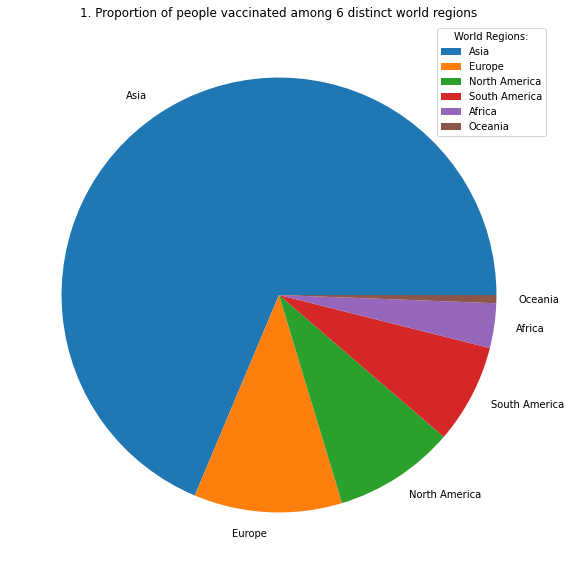

In [13]:
# 1.
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_vaccinations = df_copy.groupby('location').people_vaccinated.max().sort_values(ascending=False)
vaccinations_f = top_vaccinations.dropna(axis=0).reset_index()


# extract 6 main continents/regions
regions = vaccinations_f.query('location=="Asia" | location=="North America" | location=="South America" | location=="Africa" |location=="Europe"|location=="Oceania"')
regions_labels = ['Asia','Europe','North America','South America','Africa','Oceania']

plt.figure(figsize=(10,10))
plt.pie(regions['people_vaccinated'], labels = regions_labels)
plt.title('1. Proportion of people vaccinated among 6 distinct world regions')
plt.legend(title = "World Regions:")
plt.show()

Supplementary information: population estimates of 6 continents in the descending order  
- Asia
- Africa
- North America
- South America
- Europe
- Oceania  

From the first plot, Asia has the highest number of people vaccinated which could be due to its most-populous characteristic. Then the second top region Europe performs quite well as it doesn't have high total population originally but has second highest number of people vaccinated. On the other hand, Africa has high total population but with poor performance in terms of people vaccinated. The striking contrast could imply the vaccine inequity around the globe. Matched to our daily-life common sense, it's true that large countries in Asia and Europe (i.e. China and UK) and North America respond faster, put more efforts in developing vaccinations and carrying out suitable policies.   

Integrating each region's number of people vaccinated and corresponding population size, we can have a broad sense on the rate of transmission and emergence of new variants of each area around the world.

### 2. What are the top countries having high people vaccinated rate within their own nation?
Previously, we investigate the state of 6 main continents to grasp the global big picture regardless of the total population. Now we want to examine how individual country popularizes the vaccination within its own nation, taking its population into consideration. As some country has small population, the rate indicator could be helpful to check the generality of vaccinations in the nation overall and compare with others.

,location,people_vaccinated_per_hundred
0,Guernsey,164.19
1,Netherlands,141.98
2,Bhutan,129.52
3,Gibraltar,121.37
4,Pitcairn,100.00
5,United Arab Emirates,98.10
6,Singapore,92.99
7,Brunei,90.56
8,Cuba,89.47
9,Portugal,89.04


Text(0, 0.5, 'Percentage of people vaccinated (per hundred)')

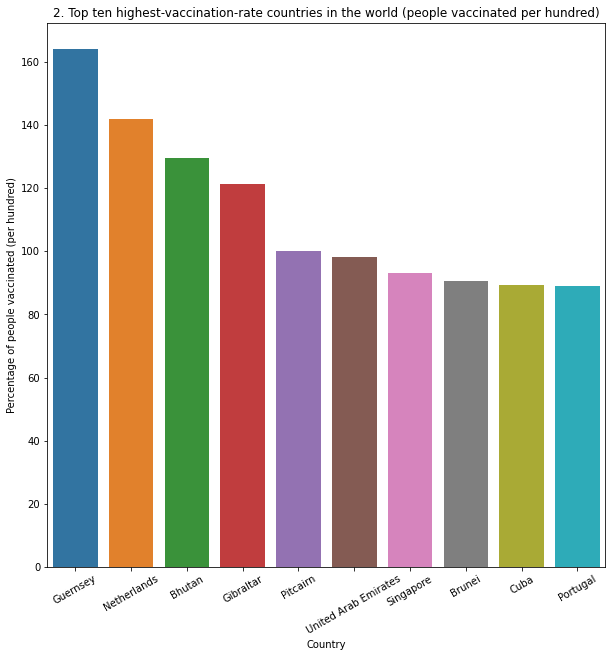

In [14]:
# 2.
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_ppl_vaccinations = df_copy.groupby('location').people_vaccinated_per_hundred.max().sort_values(ascending=False)
ppl_vaccinations_f = top_ppl_vaccinations.dropna(axis=0).reset_index()

display(ppl_vaccinations_f[0:10])

# Plotting a barplot to show top 10 vaccination rate countries
plt.figure(figsize=(10, 10))
plt.title('2. Top ten highest-vaccination-rate countries in the world (people vaccinated per hundred)')
sns.barplot(x=ppl_vaccinations_f.location[0:10], y=ppl_vaccinations_f['people_vaccinated_per_hundred'])
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.ylabel('Percentage of people vaccinated (per hundred)')

From the second plot, we could observe that most of the top 10 countries having the high vaccination rate are relatively small countries mainly located in Asia and Europe, which matches to the result of the first plot. It's quite surprising that instead of some well-kown highly-developed countries, some of those top 10 country names are barely heard of. Maybe it could be easier to popularize and implement vaccines for the countries with small population due to lower demand of vaccinations and lower population density. The call for getting vaccinated by the government could be spread out more widely and more easily to monitor how individuals respond.   

### 3. How are the booster vaccinations allocated around the globe?
Acutually even though with the current well-performed vaccination rate, the number of Covid-19 cases keeps oscillating and still rises for some countries currently in the end of 2021. At the same time, appearance of some variant viruses such as Delta & Omicron terrified people and stimulates them to look for the help from booster vaccinations.   

We'd like to explore how the supply of the boosters are allocated around the globe. Are the top countries shown above in plot 2 also perform well in implement of boosters this time.

,location,total_boosters
0,World,206304085.0
1,Upper middle income,104695754.0
2,High income,97422882.0
3,Asia,96518429.0
4,China,65730000.0
5,Europe,47033020.0
6,North America,38390479.0
7,United States,35329604.0
8,European Union,26848070.0
9,South America,23723616.0


Text(0, 0.5, 'Number of total boosters')

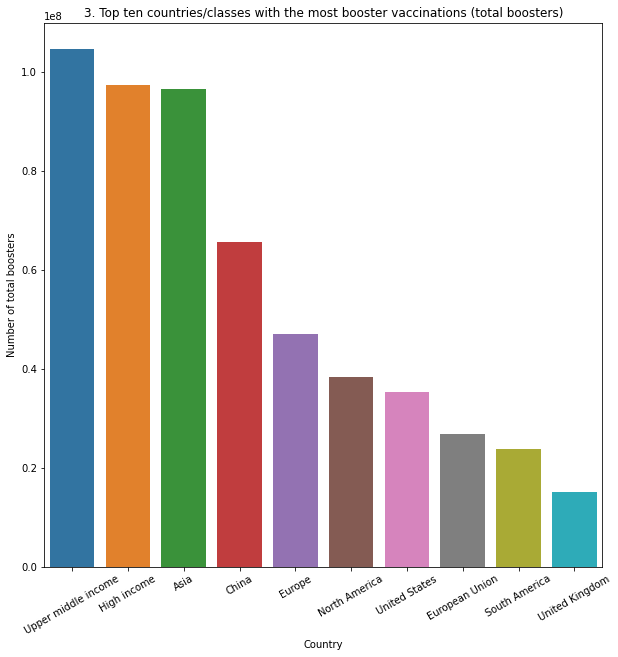

In [15]:
# 3.
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_boosters = df_copy.groupby('location').total_boosters.max().sort_values(ascending=False)
top_boosters_f = top_boosters.dropna(axis=0).reset_index()

display(top_boosters_f[0:11])

# Plotting a barplot to show top 10 countries/classes having the most booster vaccinations
plt.figure(figsize=(10, 10))
plt.title('3. Top ten countries/classes with the most booster vaccinations (total boosters)')
# exclude the first group "world"
sns.barplot(x=top_boosters_f.location[1:11], y=top_boosters_f['total_boosters'])
plt.xlabel('Country')
plt.xticks(rotation=30)
plt.ylabel('Number of total boosters')

Here except the list of countries, it also indicates that global groups with higher wealth (i.e. upper middle income and high income) overall have more demand and supply of the booster vaccines. Then some well-known mature countries/regions with larger population, more resources and more strengthed legislations provide more booster vaccinations. It makes sense that only when country progresses well in the first two vaccinations, then people start to pursue the development of the booster. Thus, it implies that those top countries should also well performed in the number of people vaccinated, total number of vaccinations, and they have enough capability and energy to do researches and diplomatic negotiations. 

From the third plot, we observe resulting classes/regions/countries that did well in boosters are quite different from the second plot. Countries well promoted vaccination rate in scenario 2 do not mean also have good supply of boosters. It may due to different paces of implementations and policies of vaccinations among distinct countries. Thus, we then need to explore deeper in the daily data to examine the speed of improvement and increment of vaccinations over time.


### 4. How's the effectiveness over time regarding to daily vaccination among different countries?
Reemphasize that due to distinct paces and policy phases on vaccinations we want to examine the speed of improvement and increment of vaccinations among different countries using the daily data.
- **4.1** We use bar plot to first identify the top countries having the best and the most effective daily vaccinations in terms of only one number - the largest number of daily vaccinations. (Here we exclude income classes and 6 continens.)
- **4.2** Then, instead of interpreting by only one max value, we plot the series of daily vaccinations over time for each top country.


,location,daily_vaccinations
3,China,22424286.0
5,India,10037995.0
9,European Union,4075834.0
11,United States,3499189.0
12,Brazil,2595170.0
...,...,...
230,Burundi,94.0
231,Niue,87.0
232,Montserrat,53.0
233,Tokelau,23.0


Text(0, 0.5, 'Number of daily vaccinations (in millions)')

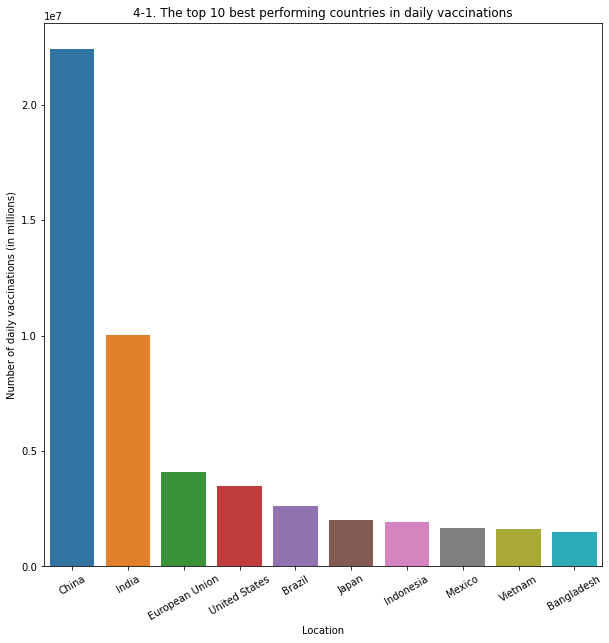

In [16]:
# 4.1
# Grouping the data by country and then sorting the data by the max value from highest to lowest
top_daily = df.groupby('location').daily_vaccinations.max().sort_values(ascending=False)
top_daily_f = top_daily.dropna(axis='rows').reset_index() # Dropping NaN values

# want to focus on countries and regions, exclude locations like "world" and income classes
top_daily_f = top_daily_f[top_daily_f.location != 'World']
top_daily_f = top_daily_f[top_daily_f.location != 'Upper middle income']
top_daily_f = top_daily_f[top_daily_f.location != 'Lower middle income']
top_daily_f = top_daily_f[top_daily_f.location != 'High income']
top_daily_f = top_daily_f[(top_daily_f.location != 'Asia') & (top_daily_f.location != 'Europe') & (top_daily_f.location != 'North America')]
top_daily_f = top_daily_f[(top_daily_f.location != 'South America') & (top_daily_f.location != 'Africa')&(top_daily_f.location != 'Australia')]

display(top_daily_f)

# Plotting the data
#with sns.plotting_context('notebook', font_scale = 1.25):
plt.figure(figsize=(10, 10))
plt.title('4-1. The top 10 best performing countries in daily vaccinations')
plt.xticks(rotation=30)
sns.barplot(x=top_daily_f.location[0:10], y=top_daily_f.daily_vaccinations[0:10])
plt.xlabel('Location')
plt.ylabel('Number of daily vaccinations (in millions)')

,location,date,daily_vaccinations
14083,India,2021-01-15,0.0
14383,Indonesia,2021-01-12,0.0
15989,Japan,2021-02-17,0.0
20645,Mexico,2020-12-24,0.0
5948,China,2020-12-15,0.0
...,...,...,...
6059,China,2021-06-29,21993000.0
6054,China,2021-06-24,21998714.0
6056,China,2021-06-26,22105857.0
6057,China,2021-06-27,22366286.0


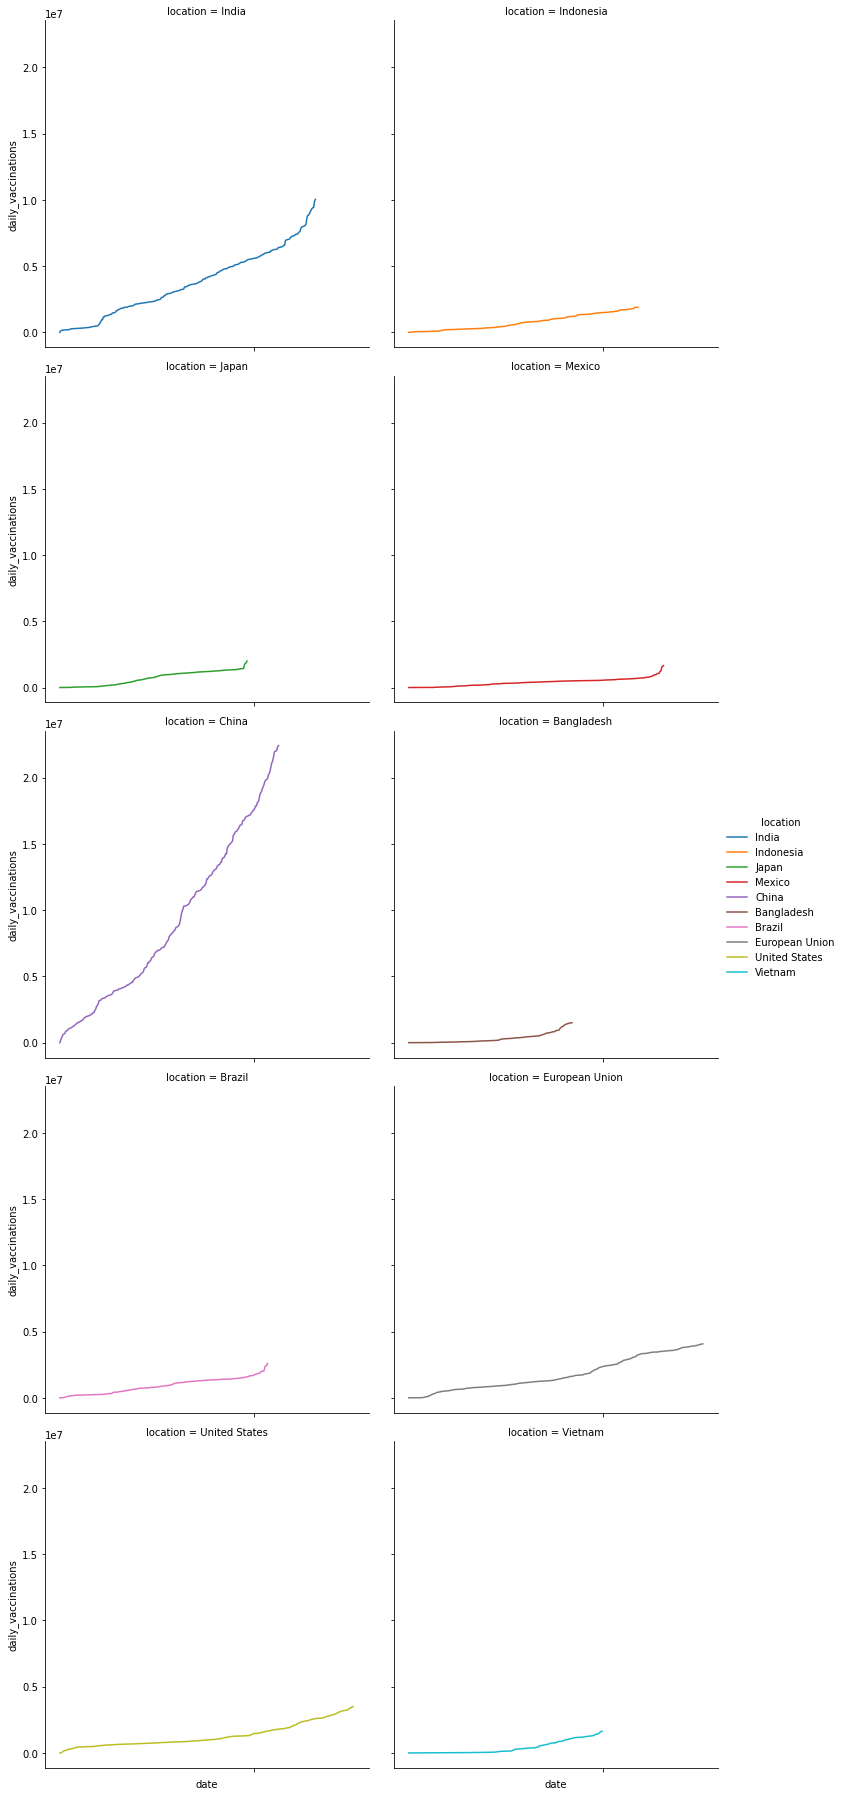

In [17]:
# 4.2
# Establishing which columns are relevant and preparing the dataset
cols = ['location', 'date', 'daily_vaccinations']
covid_df = df_copy.reset_index()

# Creating a list of the aforementioned best performing countries in terms of daily vaccinations
top_10_locations = ['China','India','European Union','United States','Brazil','Japan',
                    'Indonesia','Mexico','Vietnam','Bangladesh']


# Filtering and sorting the data
daily_vacc_df = covid_df[['location', 'date', 'daily_vaccinations']].sort_values(by='daily_vaccinations', ascending=True)
top_10_dv_df = daily_vacc_df[daily_vacc_df.location.isin(top_10_locations)].dropna()

display(top_10_dv_df) # verifying that the filtering executed correctly

# Plotting the data in a multi faceted lineplot

#plt.figure(figsize=(18, 32))
sns.relplot(data=top_10_dv_df, x='date', y='daily_vaccinations', hue='location', col='location', kind='line', col_wrap=2)
plt.xticks('')
#plt.title('4-2. Daily vaccination over time for 10 top countries')
plt.show()

The slope of each series represents the increasing speed of daily vaccination. China performs the best as there's an almost exponential increase of the vaccination rate. Then India also has an evident increase of rate in recent days. However, other countries share similar trend with steady but slow increase. We notice that Japan, Bangladesh, and Vietnam end much eariler compared to any other country. Rather than believing in that no people get vaccinated recently or some missing data exist, it is more likely due to the lack in supply of vaccinations. As large amount of Asian countries get supply from China or the US which domestically manufacture their own vaccinations, the early halt could be caused by insufficient supply and delayed shipment. Besides, earlier in this year 2021 it has related news that Japan suspended 1.6 mln doses of Moderna shot after contamination reports. Also, Vietnam vaccine shortages forced Vietnam to slow down its vaccination program in recent months [1]. Thus, those countries have to stop or slow down the process of daily vaccination in some days while large strong manufactured countries have more steady increment.
       
       

Reference:     
[1] Press, T. A. (2021, September 13). Vietnam speeds up vaccinations with over a million jabs in Hanoi over the weekend. NPR. Retrieved December 13, 2021. https://www.npr.org/2021/09/13/1036533872/vietnam-speeds-up-vaccinations-with-over-a-million-jabs-in-hanoi-over-the-weeken. 

# Part3 Model selection & Fitting to data

**Purpose:**     
Through the exploratory data analysis, we observed different trends of daily vaccination rate for different countries at last. It would be meaningful for countries to predict their future vaccination rate so that they can better adjust the social distancing metrics, policies on lockdowns, future supply of vaccines, and hospital capacity in time. Eventually achieving herd immunity may be required to end the pandemic. At the same time, for large pharmaceutical companies, the forecast would be useful to decide the future manufacturing plans of the vaccines. In order to project the time series of Covid-19 vaccination rates into the future, we choose to use the ARIMA model.

**Model:**     
The ARIMA model is fitted to time-series data either to better understand the data or to predict future points in the series. Previously, ARIMA was widely applied for infection prediction and analysis of associated vaccination. The AR (Auto Regressive) stands for the past values in the time series, the MA (Moving Average) stands for the forecasting errors, and I stands for integration sections. Summarzing in ARIMA (p, d, q):

- parameter p: the order of autoregression, number of lags observed
- parameter d: the degree of difference to ensure a stationary series
- parameter q: the order of the moving average


**Model Selection Criteria:**     
Akaike Information Criterion (AIC) is used to select the most successful ARIMA models for the dataset. The AIC is an estimator of prediction error to show how well the model fits the observed series. The most suitable model for the dataset is that have smallest AIC value [2].

**Predicted Variable:**    
As we're asked to project the time series of COVID-19 vaccination rate, we decide to interpret it as people come to get the first dose after realizing the necessity to get vaccination. Once one completes the first dose, the following fully vaccination would naturally occur. Hence, we chose to predict on the column **"people vaccinated per hundred"**. It indicates number of people who received at least one vaccine dose per 100 people in the total population of the country. As the feature converts a number to the rate by considering each country's population, it would make comparison between different countries more clear and straightforward. Thus, we believe it is the best related feature to build our ARIMA.   

Since, we have the predicted rate as result, if we want to get the number of people vaccinated, we could simply multiply the rate by its corresponding country's population.

**Process:**    
The ARIMA modeling mainly consists of 3 steps: **parameters estimation, diagnostic checking, and forecasting**. We will apply the 3 steps to do prediction on two countries: **Canada and India**. We choose India because in part2 exploratory data analysis India shows effectve increase in the daily vaccination; also it's located in South Asia and Asia performs excellently well from multiple persepectives related to vaccinations. Thus, we believe that India from Asia and Canada from North America would form a good pair to do further comparison.    

**Reference:**   
[2]. Cihan, Pınar. "Forecasting fully vaccinated people against COVID-19 and examining future vaccination rate for herd immunity in the US, Asia, Europe, Africa, South America, and the World." Applied Soft Computing 111 (2021): 107708.

### 3.1 Canada
The country has 343 samples.

In [18]:
# extract the data of Canada
ndf=df_copy.loc[df_copy['location'] == 'Canada']
#check dataframe of Canada
ndf = ndf.sort_values('people_vaccinated_per_hundred')
ndf

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
9795,Canada,CAN,2020-12-14,5.0,5.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.00,0.0,0.0,0.000
9796,Canada,CAN,2020-12-15,727.0,727.0,0.0,0.0,722.0,722.0,0.00,0.00,0.00,0.00,19.0,722.0,0.002
9797,Canada,CAN,2020-12-16,3016.0,3016.0,0.0,0.0,2289.0,1506.0,0.01,0.01,0.00,0.00,40.0,1506.0,0.004
9798,Canada,CAN,2020-12-17,7267.0,7267.0,0.0,0.0,4251.0,2421.0,0.02,0.02,0.00,0.00,64.0,2421.0,0.006
9799,Canada,CAN,2020-12-18,11276.0,11276.0,0.0,0.0,4009.0,2818.0,0.03,0.03,0.00,0.00,74.0,2818.0,0.007
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10133,Canada,CAN,2021-11-17,59776509.0,30102545.0,28764923.0,909041.0,76112.0,61164.0,157.03,79.08,75.56,2.39,1607.0,14376.0,0.038
10134,Canada,CAN,2021-11-18,59852559.0,30121803.0,28795770.0,934986.0,76050.0,66659.0,157.23,79.13,75.64,2.46,1751.0,15696.0,0.041
10135,Canada,CAN,2021-11-19,59918117.0,30136287.0,28821607.0,960223.0,65558.0,62649.0,157.40,79.16,75.71,2.52,1646.0,14717.0,0.039
10136,Canada,CAN,2021-11-20,59947684.0,30145291.0,28837538.0,964855.0,29567.0,62168.0,157.48,79.19,75.75,2.53,1633.0,14706.0,0.039


#### 3.1.1 Parameters Estimation (of d):    
Before we start the ARIMA modeling, we want to make the time series stationary as independent of trend and seasonality; otherwise, the values of time series would be affected. To achieve a stationary series, we can modify the parameter d by doing differencing for stabilizing the mean of the series around at 0.    

We observe the autocorrelation plots below to see if first-order differencing (d=1) is sufficient to remove all the trend and seasonality. If not, we could increase the order of differencing to get a stationary time series. 

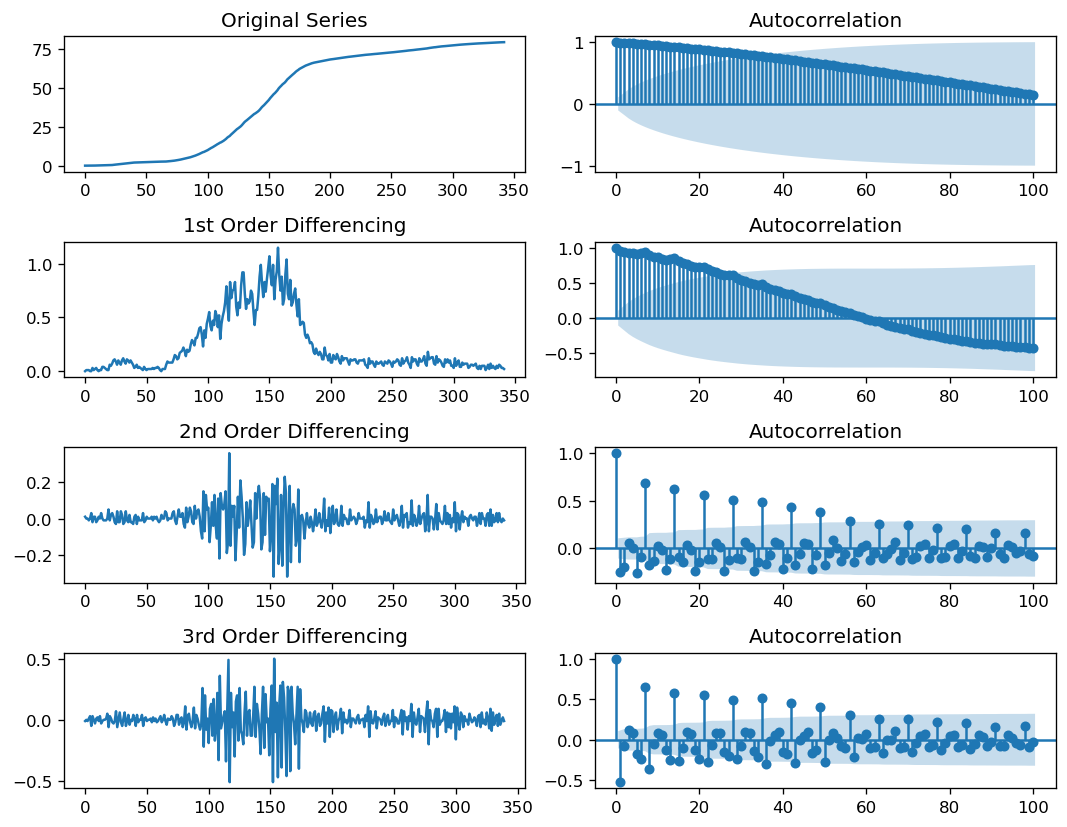

In [19]:
#Get the values from the column where vaccination rate of Canada is stored.
val = ndf['people_vaccinated_per_hundred'].values

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})

# Original Series
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1],lags=100)

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1],lags=100)
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1],lags=100)
diffval = np.diff(diffval)

# 3rd Differencing
axes[3, 0].plot(np.diff(diffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[3, 1],lags=100)
plt.tight_layout()
plt.show()

#### 3.1.1 Parameters Estimation (continued):
From the differencing and autocorrelation plots, we could say that the second order differencing is sufficient to make the time series stationary, d=2. To further decide d and the other parameters, we use the method based on grid search to find the best model by minimizing AIC score.    

The pyramid-arima library for Python contains an **auto_arima** function that allows us to set a range of parameters p,d,q values and then fit models for all the possible combinations. Then the model will keep the combination that reported back the best AIC value. 
- first we let **auto_arima** function has its own default values
- then based on the result, we manually define inputs in the **auto_arima** function to see more combinations and double check the best model


In [20]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

# default values of auto_arima function
stepwise_fit = pm.auto_arima(val, trace=True, suppress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-829.925, Time=0.19 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-776.375, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-796.401, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-819.566, Time=0.05 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-831.934, Time=0.09 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-833.339, Time=0.09 sec
 ARIMA(0,2,3)(0,0,0)[0]             : AIC=-831.975, Time=0.16 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-829.548, Time=0.10 sec
 ARIMA(1,2,3)(0,0,0)[0]             : AIC=-836.736, Time=0.35 sec
 ARIMA(2,2,3)(0,0,0)[0]             : AIC=-879.474, Time=0.44 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=-890.513, Time=0.49 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=-835.039, Time=0.38 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=-828.372, Time=0.52 sec
 ARIMA(3,2,4)(0,0,0)[0]             : AIC=-883.458, Time=0.72 sec
 ARIMA(2,2,4)(0,0,0)[0]          

In [21]:
# manually define inputs in the auto_arima function
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=5, max_q=4, # maximum p and q
m=1, # frequency of series
d=2, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-827.550, Time=0.24 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-774.375, Time=0.06 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-794.401, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-817.567, Time=0.10 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-776.375, Time=0.02 sec
 ARIMA(2,2,1)(0,0,0)[0] intercept   : AIC=-829.741, Time=0.30 sec
 ARIMA(2,2,0)(0,0,0)[0] intercept   : AIC=-818.651, Time=0.09 sec
 ARIMA(3,2,1)(0,0,0)[0] intercept   : AIC=-827.765, Time=0.37 sec
 ARIMA(2,2,2)(0,0,0)[0] intercept   : AIC=-827.927, Time=0.38 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-829.936, Time=0.19 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-831.341, Time=0.19 sec
 ARIMA(0,2,3)(0,0,0)[0] intercept   : AIC=-829.977, Time=0.33 sec
 ARIMA(1,2,3)(0,0,0)[0] intercept   : AIC=-834.738, Time=0.82 sec
 ARIMA(2,2,3)(0,0,0)[0] intercept   : AIC=-851.688, Time=0.71 sec
 ARIMA(3,2,3)(0,0,0)[0] intercept

If we let the auto_arima function has its own default values, we get the best model **ARIMA(5, 2, 4)** with AIC=-1016.603, where the order of differencing matches to our previous assumption that d=2 by plotting the time-series autocorrelation plot.

Then to double check the best model, we manually adjust the auto_arima function. We fix d=2 as it has been proven twice suitable in this case. And we choose max_p=5, max_q=4 which we got previously. We do not increase the max p and q because we want to avoid model being over complicated and use fewer features as possible. With the result table, we get more combinations of different parameters and again get the best model **ARIMA(5, 2, 4)**.   

Finally, we are settled with the best model **ARIMA(5, 2, 4)**.

#### 3.1.2 Diagnostic Checking:

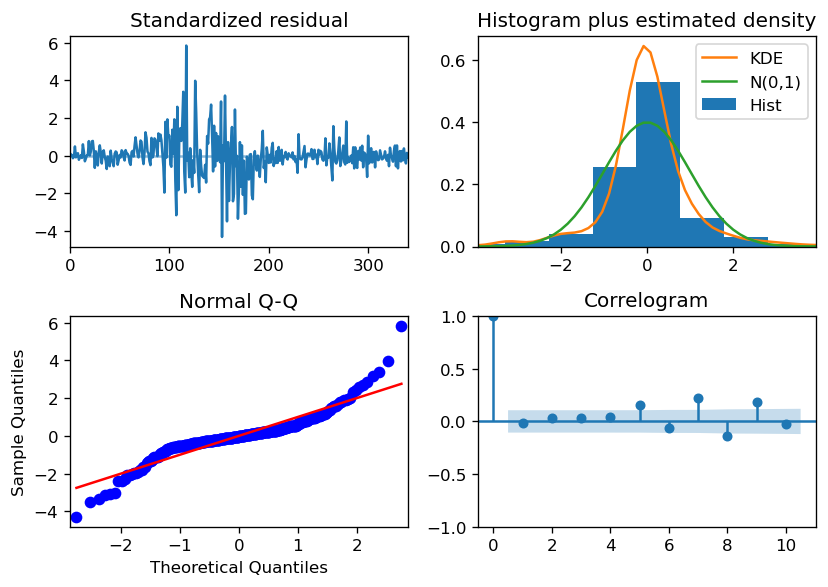

In [22]:
#visualize the result of the best model
model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

From the above first three subplots, the standardized residual looks like the white noise, having mean around 0 and following a normal distribution. Though the normal Q-Q plot shows several outliers at the right tail, it is still acceptable because the overall trend looks good. The last subplot of ACF of the standardized residuals shows no apparent correlation with lagged versions of itself, except only few ACF values exceeding the 95% confidence band, but also acceptable. Thus, we could say that **ARIMA(5, 2, 4)** is a suitable model for our time-series dataset.

#### 3.1.3 Forecast: (Canada)

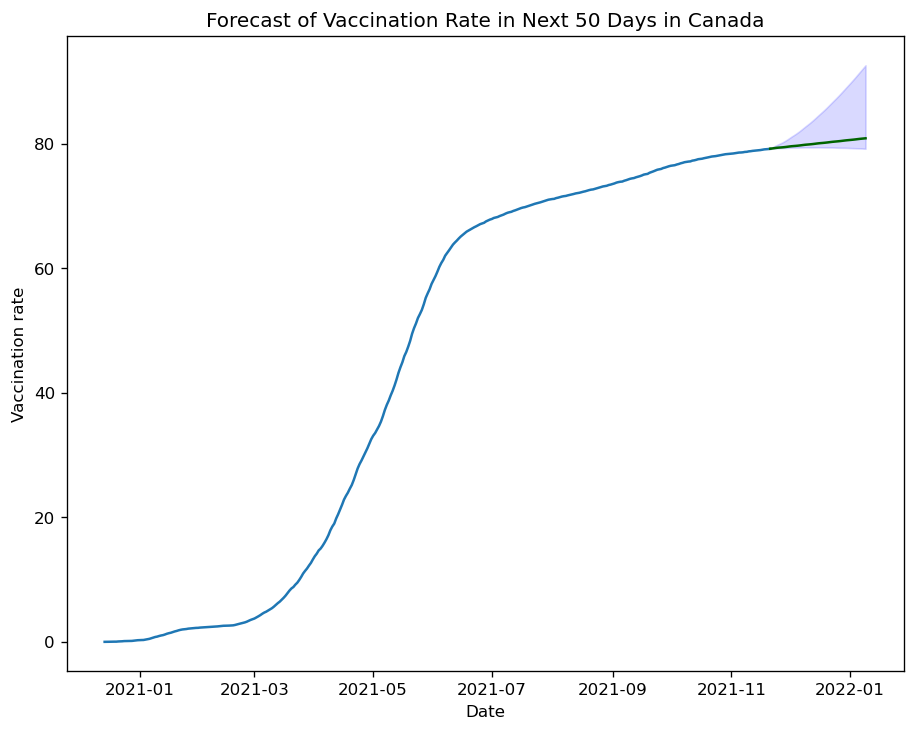

In [23]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
fc2, confint2 = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.78)

# x-axis show the exact dates
index_of_fc = pd.date_range('2021-11-21',periods=n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint2[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
ndf['date']=pd.to_datetime(ndf['date'])
plt.plot(ndf.date,val)
plt.plot(fc_series, color='darkgreen')
plt.xlabel('Date')
plt.ylabel('Vaccination rate')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccination Rate in Next 50 Days in Canada")
plt.show()

#plt.gca().xaxis.set_major_formatter(mdate.DateFormatter('%Y-%m-%d'))
#plt.gca().xaxis.set_major_locator(mdate.DayLocator(interval=60)) 
#plt.gca().set_xbound(left, right)

In [24]:
# get Canadian population
population_df = pd.read_csv('Complete_covid19_dataset.csv')
population = population_df[['location','population']]
population[population.location=='Canada']

,location,population
21310,Canada,38067913.0
21311,Canada,38067913.0
21312,Canada,38067913.0
21313,Canada,38067913.0
21314,Canada,38067913.0
...,...,...
21969,Canada,38067913.0
21970,Canada,38067913.0
21971,Canada,38067913.0
21972,Canada,38067913.0


In [25]:
# convert rate to number of people vaccinated per hundred
# number of people will be vaccinated in the next 50 days in Canada
#base-case scenario
print('(Base) Number of people will be vaccinated in next 50 days in Canada:', 
      (fc[-1]-list(ndf.people_vaccinated_per_hundred)[-1]) * 380679.13)

#best-case scenario
print('(Best) Number of people will be vaccinated in next 50 days in Canada:', 
      (upper_series[-1]-list(ndf.people_vaccinated_per_hundred)[-1]) * 380679.13)

#worst-case scenario
print('(Worst) Number of people will be vaccinated in next 50 days in Canada:', 
      (lower_series[-1]-list(ndf.people_vaccinated_per_hundred)[-1]) * 380679.13)

(Base) Number of people will be vaccinated in next 50 days in Canada: 646280.5210171778
(Best) Number of people will be vaccinated in next 50 days in Canada: 5112668.686453186
(Worst) Number of people will be vaccinated in next 50 days in Canada: 9765.136205204923


**Results:**    
Based on ARIMA(5, 2, 4), we visualize the prediction in an "S"-shape curve above. The curve forecasts the vaccination rate dated from 2021 Dec to 2022 Jan. The dark bluegreen real line is the base case. The **best-case scenario** is built based on the highest range of 95% confidence interval of the base case. Having a common sense, the vaccination rate/number of people vaccinated should keep increasing or at least remain the same along with the increasing date. In order to align with the standard, we achieve the non-decreasing **worst-case scenario** based on the lowest range of 22% confidence interval of the base case.

**According to the forecast we've done, how many people will be vaccinated in the next 50 days in Canada?**    
We design the formula to calculate the number of people will be vaccinated =          

<div align="center"> (vaccination rate at the end of the 50 day - the last vaccination rate before the 50-day prediction) $\times$ Canadian Population
</div>

After we achieve the population of Canada=38,067,913 (380679.13 by per hundred) in Complete_covid19_dataset.csv, we finally get the results:
- In **best case**: 5,112,668.686 people will be vaccinated in next 50 days in Canada
- In **base case**: 646,280.521 people will be vaccinated in next 50 days in Canada (95% confidence interval)
- In **worst case**: 9,765.136 people will be vaccinated in next 50 days in Canada. However due to the low 22% confidence interval we have rather low probability to get the number 9,765.136. Thus, we could even conclude that only few or even zero people will be vaccinated under the worst case.


### 3.2 India
The country has 300 samples.

In [26]:
# extract the data of India
ndf_india=df_copy.loc[df_copy['location'] == 'India']

#check dataframe of India
ndf_india = ndf_india.sort_values('people_vaccinated_per_hundred')
ndf_india

,location,iso_code,date,total_vaccinations,people_vaccinated,people_fully_vaccinated,total_boosters,daily_vaccinations_raw,daily_vaccinations,total_vaccinations_per_hundred,people_vaccinated_per_hundred,people_fully_vaccinated_per_hundred,total_boosters_per_hundred,daily_vaccinations_per_million,daily_people_vaccinated,daily_people_vaccinated_per_hundred
25869,India,IND,2021-01-15,0.000000e+00,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.000
25870,India,IND,2021-01-16,1.911810e+05,191181.0,0.0,0.0,191181.0,191181.0,0.01,0.01,0.00,0.0,137.0,191181.0,0.014
25871,India,IND,2021-01-17,2.243010e+05,224301.0,0.0,0.0,33120.0,112150.0,0.02,0.02,0.00,0.0,80.0,112150.0,0.008
25872,India,IND,2021-01-18,4.540490e+05,454049.0,0.0,0.0,229748.0,151350.0,0.03,0.03,0.00,0.0,109.0,151350.0,0.011
25873,India,IND,2021-01-19,6.748350e+05,674835.0,0.0,0.0,220786.0,168709.0,0.05,0.05,0.00,0.0,121.0,168709.0,0.012
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26175,India,IND,2021-11-17,1.141007e+09,758251605.0,382755102.0,0.0,7318494.0,6171477.0,81.89,54.42,27.47,0.0,4429.0,1807766.0,0.130
26176,India,IND,2021-11-18,1.148787e+09,760532284.0,388254602.0,0.0,7780179.0,6573042.0,82.44,54.58,27.86,0.0,4717.0,1951437.0,0.140
26177,India,IND,2021-11-19,1.153596e+09,762169283.0,391426273.0,0.0,4808670.0,6024606.0,82.79,54.70,28.09,0.0,4324.0,1855689.0,0.133
26178,India,IND,2021-11-20,1.163685e+09,765364845.0,398320160.0,0.0,10089449.0,6357807.0,83.51,54.93,28.59,0.0,4563.0,1983320.0,0.142


#### 3.2.1 Parameters Estimation (of d):    

We observe the autocorrelation plots below to see if first-order differencing (d=1) is sufficient to remove all the trend and seasonality. If not, we could increase the order of differencing to get a stationary time series. 

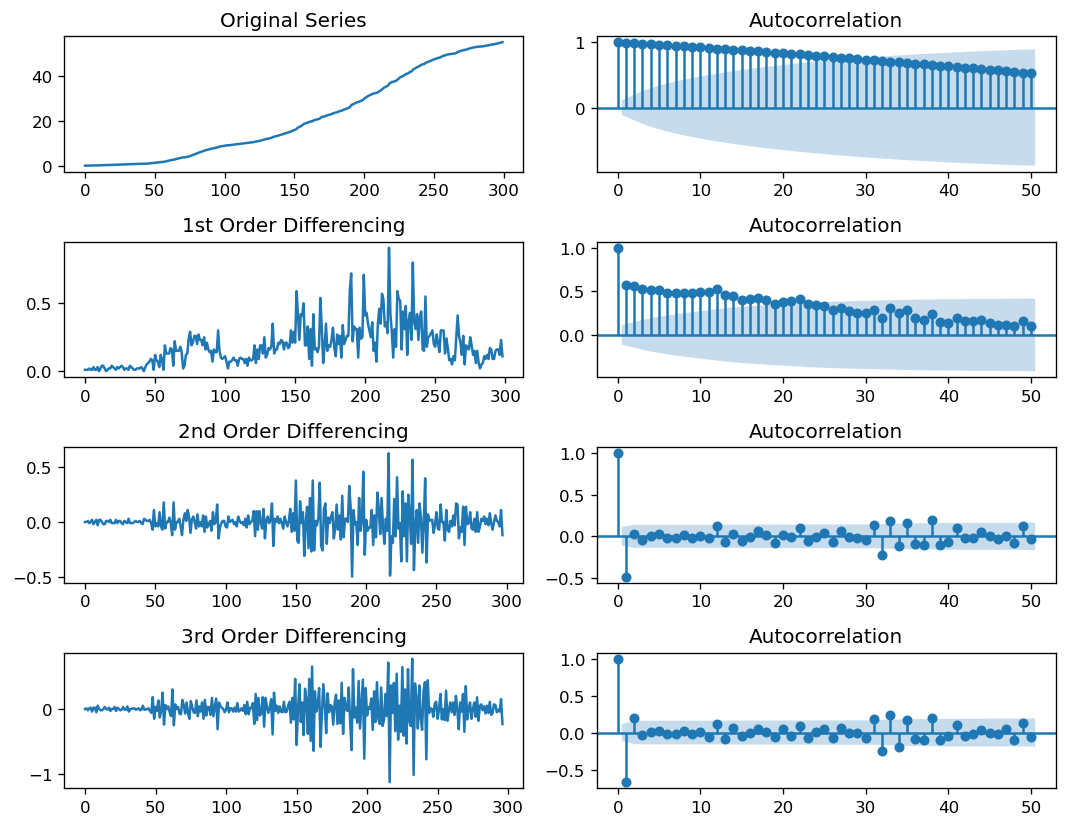

In [27]:
#Get the values from the column where vaccination rate of India is stored.
val = ndf_india['people_vaccinated_per_hundred'].values

# Original Series
fig, axes = plt.subplots(4, 2)
axes[0, 0].plot(val); axes[0, 0].set_title('Original Series')
plot_acf(val, ax=axes[0, 1],lags=50)

# 1st Differencing
axes[1, 0].plot(np.diff(val)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(val), ax=axes[1, 1],lags=50)
diffval = np.diff(val)

# 2nd Differencing
axes[2, 0].plot(np.diff(diffval)); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[2, 1],lags=50)
diffval = np.diff(diffval)

# 3rd Differencing
axes[3, 0].plot(np.diff(diffval)); axes[3, 0].set_title('3rd Order Differencing')
plot_acf(np.diff(diffval), ax=axes[3, 1],lags=50)
plt.tight_layout()
plt.show()

#### 3.2.1 Parameters Estimation (continued):
From the differencing and autocorrelation plots for India dataset, we could also say that the second order differencing is sufficient to make the time series stationary, d=2. To further decide d and the other parameters, we do the grid search to find the best model by minimizing AIC score.    

Recall the **auto_arima** function in pyramid-arima library. 
- first we let **auto_arima** function has its own default values
- then based on the result, we manually define inputs in the **auto_arima** 

In [28]:
# let auto_arima function has its own default values
stepwise_fit = pm.auto_arima(val, trace=True, suppress_warning=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=-473.005, Time=0.30 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-334.721, Time=0.02 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-412.767, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-477.828, Time=0.12 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-476.394, Time=0.11 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-476.339, Time=0.08 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-473.834, Time=0.11 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-475.994, Time=0.12 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.904 seconds


In [29]:
# manually define inputs in the auto_arima function
model = pm.auto_arima(val, start_p=1, start_q=1,
test='adf', # use adftest to find optimal 'd'
max_p=3, max_q=3, # maximum p and q
m=1, # frequency of series
d=2, # let model determine 'd'
seasonal=False, # No Seasonality
start_P=0,
D=0,
trace=True,
error_action='ignore',
suppress_warnings=True,
stepwise=True)
print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-474.569, Time=0.18 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-332.723, Time=0.05 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-410.777, Time=0.07 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-475.994, Time=0.11 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-334.721, Time=0.02 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-474.513, Time=0.15 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-472.000, Time=0.25 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-477.828, Time=0.10 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-476.394, Time=0.10 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-476.339, Time=0.08 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-412.767, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-473.834, Time=0.11 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 1.266 seconds
                               SARIMAX Results                                
Dep. Vari

If we let the auto_arima function has its own default values, we get the best model **ARIMA(0, 2, 1)**, where the order of differencing matches to our previous assumption that d=2 by plotting the time-series autocorrelation plot.

Then to double check the best model, we manually adjust the auto_arima function. We fix d=2 as it has been proven twice suitable in this case. And we choose max_p=3, max_q=3 to avoid model being over complicated and use fewer features as possible. With the result table, we get more combinations of different parameters and again get the best model **ARIMA(0, 2, 1)**. The parameter p =0 means the model doesn't depend on the lagged terms.   

Finally, we are settled with the best model **ARIMA(0, 2, 1)**.

#### 3.2.2 Diagnostic Checking:

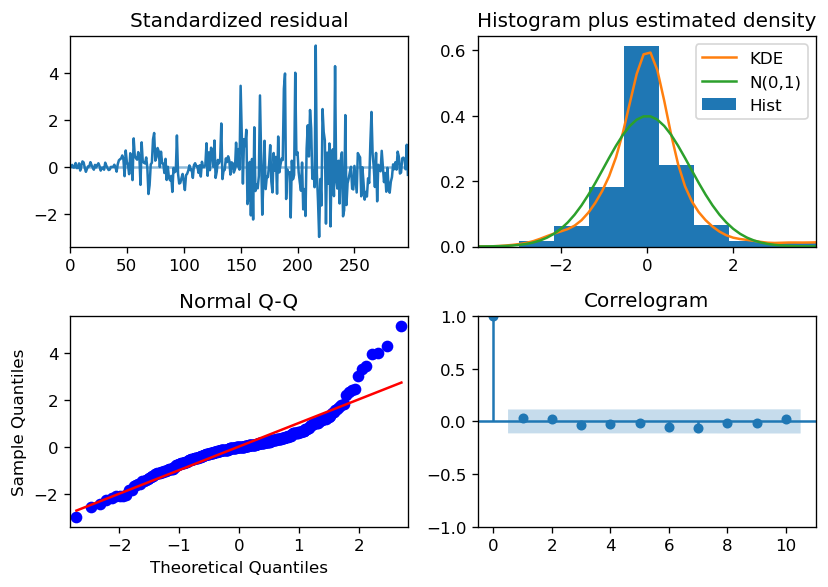

In [30]:
#visualize the result of the best model
model.plot_diagnostics(figsize=(7,5))
plt.tight_layout()
plt.show()

From the above first three subplots, the standardized residual looks like the white noise, having mean around 0 and following a normal distribution. Though the normal Q-Q plot shows several outliers at the right tail, it is still acceptable because the overall trend looks good. The last subplot of ACF of the standardized residuals shows no apparent correlation with lagged versions of itself, almost all of the ACF values are within the 95% confidence band. Thus, we could say that **ARIMA(0, 2, 1)** is a suitable model fitted well to our time-series dataset.

#### 3.2.3 Forecast: (India)

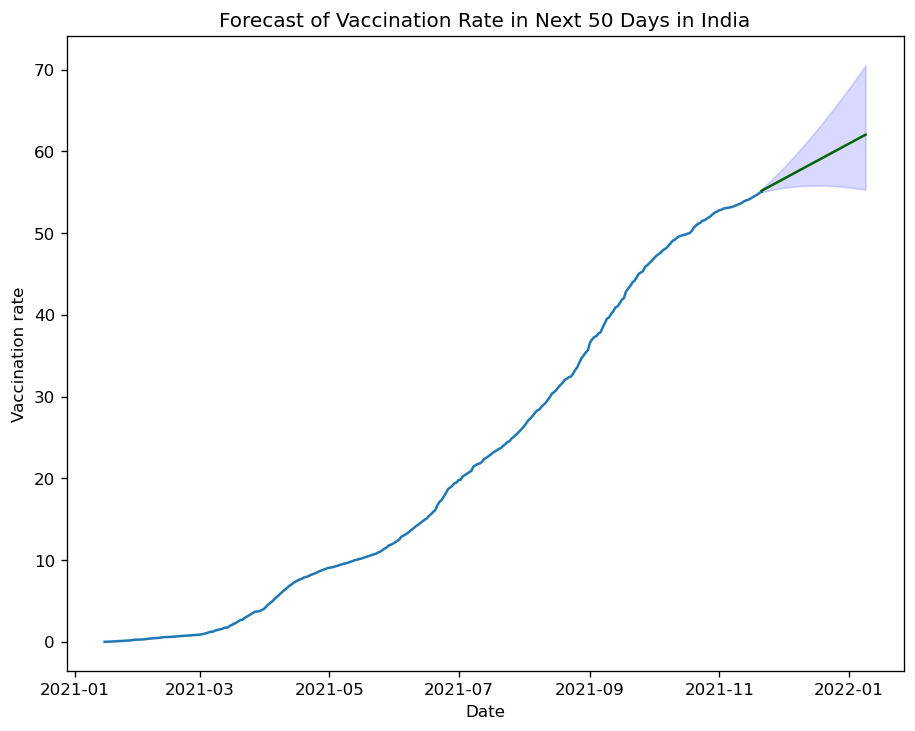

In [32]:
# Forecast
n_periods = 50
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
fc2, confint2 = model.predict(n_periods=n_periods, return_conf_int=True,alpha=0.12)
index_of_fc = pd.date_range('2021-11-21',periods=n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint2[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
ndf_india['date']=pd.to_datetime(ndf_india['date'])
plt.plot(ndf_india.date, val)
plt.plot(fc_series, color='darkgreen')
plt.xlabel('Date')
plt.ylabel('Vaccination rate')
plt.fill_between(lower_series.index,
lower_series,
upper_series,
color='b', alpha=.15)
plt.title("Forecast of Vaccination Rate in Next 50 Days in India")

plt.show()

In [33]:
# get Indian population
population[population.location=='India']

,location,population
55064,India,1.393409e+09
55065,India,1.393409e+09
55066,India,1.393409e+09
55067,India,1.393409e+09
55068,India,1.393409e+09
...,...,...
55719,India,1.393409e+09
55720,India,1.393409e+09
55721,India,1.393409e+09
55722,India,1.393409e+09


In [34]:
# Indian population
numb_series = list(population[population.location=='India'].population)
numb_series[1]

1393409033.0

In [35]:
# convert rate to number of people vaccinated per hundred
# number of people will be vaccinated in the next 50 days in India
#base-case scenario
print('(Base) Number of people will be vaccinated in next 50 days in India:', 
      (fc[-1]-list(ndf_india.people_vaccinated_per_hundred)[-1]) * 13934090.33)

#best-case scenario
print('(Best) Number of people will be vaccinated in next 50 days in India:', 
      (upper_series[-1]-list(ndf_india.people_vaccinated_per_hundred)[-1]) * 13934090.33)

#worst-case scenario
print('(Worst) Number of people will be vaccinated in next 50 days in India:', 
      (lower_series[-1]-list(ndf_india.people_vaccinated_per_hundred)[-1]) * 13934090.33)


(Base) Number of people will be vaccinated in next 50 days in India: 97423811.7608573
(Best) Number of people will be vaccinated in next 50 days in India: 215713083.13586855
(Worst) Number of people will be vaccinated in next 50 days in India: 3588906.0642978237


**Results:**    
Based on ARIMA(0, 2, 1), we visualize the prediction in an approximately linearly-increasing shape curve above. The curve forecasts the vaccination rate dated from 2021 Dec to 2022 Jan. The dark bluegreen real line is the base case. The **best-case scenario** is built based on the highest range of 95% confidence interval of the base case.  In order to ensure the vaccination rate non-decreasing, we achieve the **worst-case scenario** based on the lowest range of 88% confidence interval of the base case.

**According to the forecast we've done, how many people will be vaccinated in the next 50 days in India?**    

Recall the formula to calculate the number of people will be vaccinated.
After we achieve the population of India=1,393,409,033 (13,934,090.33 by per hundred) in Complete_covid19_dataset.csv, we finally get the results:
- In **best case**: 215,713,083.136 people will be vaccinated in next 50 days in India
- In **base case**: 97,423,811.761 people will be vaccinated in next 50 days in India (95% confidence interval)
- In **worst case**: 3,588,906.064 people will be vaccinated in next 50 days in India. But need to notice the 88% confidence interval. What that means, it still exists some minor probability that the number of people vaccinated would be much less than the number forecasted now.


# Part4. Relating COVID19 Vaccination to a Second Dataset

### 4.1 Choose the data
Choose the another dataset as Complete_covid19_dataset.csv, we also drop the total_vaccinations missing data as the same process in part 1. The dataset supplements the Covid-19 vaccination information from aspects of new cases, new deaths, number of icu patients, hospital admissions, population density, handwashing facilities, and etc.

We choose to examine and analyze the **new death rate (expressed in smoothed per million)** associated with the Covid-19 vaccination rate because death rate is a key indicator to track the evolution of the Covid-19 pandemic and any new coronavirus variant. People were terrified by the Covid 19 at first because the novel virus was one of the leading cause of death for children and older age groups, ranking only behind heart disease and cancer [3]. An steady and decreasing death rate could imply effective government policies, effective vaccination programs and sufficient hospital and care admissions. Thus the factor is important and smoothed data helps us to see more clearly about the data trend.    

**Reference:**     
[3] Koh, Howard K., Alan C. Geller, and Tyler J. VanderWeele. "Deaths from COVID-19." JAMA 325.2 (2021): 133-134.

In [36]:
# select the second dataset Complete_covid19_dataset.csv
df2 = pd.read_csv('Complete_covid19_dataset.csv')
df2 = df2.drop(df2[df2.total_vaccinations.isna()].index)
# check the features
df2.columns

Index(['iso_code', 'continent', 'location', 'date', 'total_cases', 'new_cases',
       'new_cases_smoothed', 'total_deaths', 'new_deaths',
       'new_deaths_smoothed', 'total_cases_per_million',
       'new_cases_per_million', 'new_cases_smoothed_per_million',
       'total_deaths_per_million', 'new_deaths_per_million',
       'new_deaths_smoothed_per_million', 'reproduction_rate', 'icu_patients',
       'icu_patients_per_million', 'hosp_patients',
       'hosp_patients_per_million', 'weekly_icu_admissions',
       'weekly_icu_admissions_per_million', 'weekly_hosp_admissions',
       'weekly_hosp_admissions_per_million', 'new_tests', 'total_tests',
       'total_tests_per_thousand', 'new_tests_per_thousand',
       'new_tests_smoothed', 'new_tests_smoothed_per_thousand',
       'positive_rate', 'tests_per_case', 'tests_units', 'total_vaccinations',
       'people_vaccinated', 'people_fully_vaccinated', 'total_boosters',
       'new_vaccinations', 'new_vaccinations_smoothed',
       't

In [37]:
# extract some of the features that we want to do further analysis
df2 = df2[['iso_code','continent','location','date','new_cases','new_deaths_smoothed',
          'new_deaths_smoothed_per_million','icu_patients',
          'hosp_patients','total_vaccinations','people_vaccinated','total_vaccinations_per_hundred','people_vaccinated_per_hundred']]
df2_can = df2[df2.location == 'Canada']
# check the missing data for Canada
df2_can.isna().sum()

iso_code                           0
continent                          0
location                           0
date                               0
new_cases                          0
new_deaths_smoothed                0
new_deaths_smoothed_per_million    0
icu_patients                       1
hosp_patients                      1
total_vaccinations                 0
people_vaccinated                  0
total_vaccinations_per_hundred     0
people_vaccinated_per_hundred      0
dtype: int64

In [38]:
# check the missing data for India
df2_india = df2[df2.location == 'India']
df2_india.isna().sum()

iso_code                             0
continent                            0
location                             0
date                                 0
new_cases                            0
new_deaths_smoothed                  0
new_deaths_smoothed_per_million      0
icu_patients                       298
hosp_patients                      298
total_vaccinations                   0
people_vaccinated                    0
total_vaccinations_per_hundred       0
people_vaccinated_per_hundred        0
dtype: int64

We mainly analyze the correlation between the **vaccination rate (total_vaccinations_per_hundred)** and the **new death rate (new_deaths_smoothed_per_million )**. Notice that for both Canada and India, the two features do not have any missing values; thus, we decide not to do any further data cleaning.

### 4.2 Correlation exploration

In [39]:
# use pearson's correlation coefficient
from scipy.stats import pearsonr
corr, _ = pearsonr(df2_can['people_vaccinated_per_hundred'], df2_can['new_deaths_smoothed_per_million'])
print("Pearson's correlation for Canada: %.3f" % corr)

corr, _ = pearsonr(df2_india['people_vaccinated_per_hundred'], df2_india['new_deaths_smoothed_per_million'])
print("Pearson's correlation for India: %.3f" % corr)

Pearson's correlation for Canada: -0.719
Pearson's correlation for India: -0.230


In [40]:
# use spearman correlation coefficient
from scipy.stats import spearmanr
corr, _ = spearmanr(df2_can['people_vaccinated_per_hundred'], df2_can['new_deaths_smoothed_per_million'])
print('Spearman correlation for Canada: %.3f' % corr)

corr, _ = spearmanr(df2_india['people_vaccinated_per_hundred'], df2_india['new_deaths_smoothed_per_million'])
print('Spearman correlation for India: %.3f' % corr)

Spearman correlation for Canada: -0.662
Spearman correlation for India: 0.227


We appied two types of methods to examine the correlation between vaccination rate and new death rate.   
- **Pearson correlation**: measure of linear correlation between two sets of data based on the method of covariance.      

    **The Pearson's correlation for Canada** is -0.719, indicating a negative linear relationship between two factors. As the vaccination rate increases, the new death rate decreases. The medium-large value 0.719 indicates relatively strong correlation.    
    
    **The Pearson's correlation for India** is -0.23, also indicating a negative linear relationship between two factors. As the vaccination rate increases, the new death rate decreases. However, the value 0.23 is relatively small so that those two factors have average/weak linear correlation. We could further explore if they have some strong non-linear correlation.       
    
      
- **Spearman correlation**: evaluates the monotonically non-parametric relationship based on the ranked values for each variable rather than the raw data. The benefit is that the test does not carry any assumptions about the distribution of the data and we suitably have ordinal data in this case. The drawback is that if our data is not monotonic as a whole, then the correlation result would be deteriorated.       

    **The Spearman correlation for Canada** is -0.662, indicating a negative monotonic relationship which matches to the pearson's result.      
    
    **The Spearman correlation for India** is 0.227, surprisingly a positive relationship which contrasts with the result of pearson. Also the value 0.227 is small.   
    
**In conclusion**, we have some clear vision on the two factors' negative correlation for Canada; however, the case in India is somehow conflicting. But a meaningful relationship can still exist even if the correlation coefficients are small. Hence, we will visualize the two factors next under Canada and India.

### 4.3 Visualize the correlation

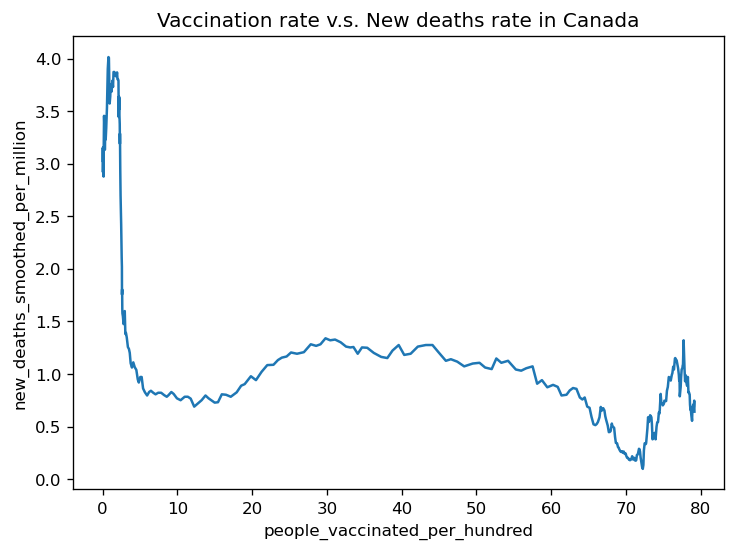

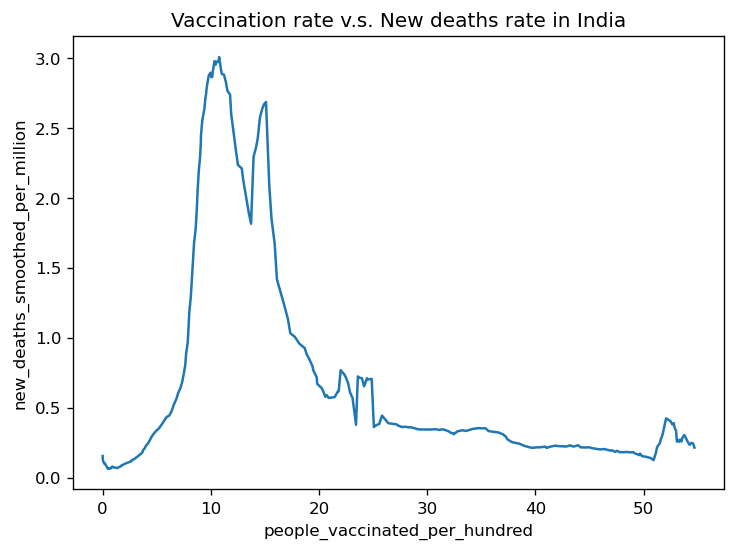

In [41]:
# plot the series of the two factors to check the correlation
# Canada
plt.figure(figsize=(7,5))
plt.plot(df2_can['people_vaccinated_per_hundred'],df2_can['new_deaths_smoothed_per_million'])
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title('Vaccination rate v.s. New deaths rate in Canada')
plt.show()

# India
plt.figure(figsize=(7,5))
plt.plot(df2_india['people_vaccinated_per_hundred'],df2_india['new_deaths_smoothed_per_million'])
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title('Vaccination rate v.s. New deaths rate in India')
plt.show()

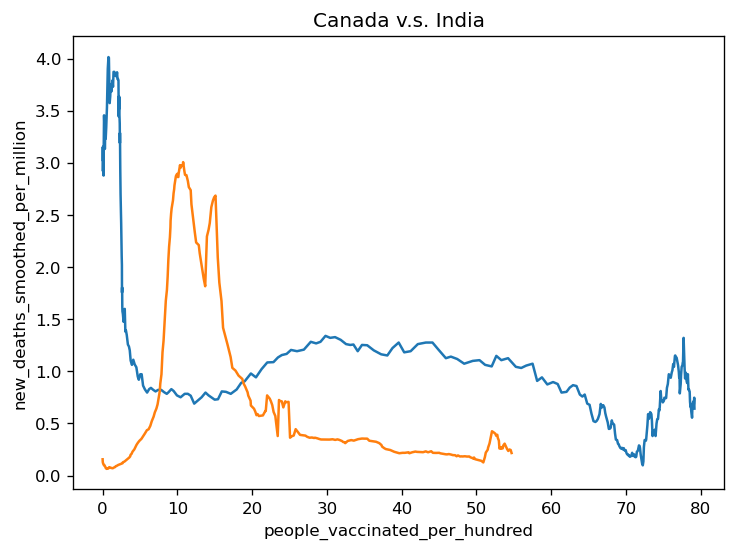

In [42]:
# plot series together
plt.figure(figsize=(7,5))
plt.plot(df2_can['people_vaccinated_per_hundred'],df2_can['new_deaths_smoothed_per_million'])
plt.plot(df2_india['people_vaccinated_per_hundred'],df2_india['new_deaths_smoothed_per_million'])
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title('Canada v.s. India')
plt.show()

**Canada:**

The plot of vaccination rate v.s. new deaths rate matches to the result of two previous correlation coefficients. The new death rate overall decreases sharply when vaccination rate increases. However, the decrease doesn't occur in a continuously monotonic way. At first the new death rate has a small bump of increase maybe due to the delay/lag effect of vaccinations. Also, when the vaccination rate hits new high in recent days, the new death rate climbs up a little bit maybe due to the new coronavirus variants. The two doses of vaccinations may lose effectiveness along with the time and new booster could be required.    

**India:**

The effect of vaccination comes later in this case as India may developed and manufactred vaccines at different pace. At first, there's a large rise of the new deaths rate at the initial increase of the vaccination rate maybe also due to the delay/lag effect of vaccinations. Then after the vaccination rate reaches to 15%, the new deaths rate starts to decrease in an exponential-decay way. The non-linear and non-monotonic characteristics explain the conflicting and small-value pearson & spearman correlation coefficients before. But there still exists some evident and inspiring relationship between the vaccination rate and new deaths rate for India.

### 4.4 Fit model to illustrate the correlation
From the two plots above, we observe some exponential decaying trend of the new deaths rate for both countries when vaccination rate increases. Thus, we want to fit the data with an exponential model, use scipy.optimize.curve_fit to tune the parameters, and finally check the predicted results with the actual data.    

In [43]:
# define the exponential model to fit data 
def model_func(x, A, t, b):
    return A * np.exp(-t * x) + b

R² = 0.7903112851625331
relation can be expressed as: Y = 2.991650247058581 * e^(-0.2448560892500785 * x) + 0.7154373088645603


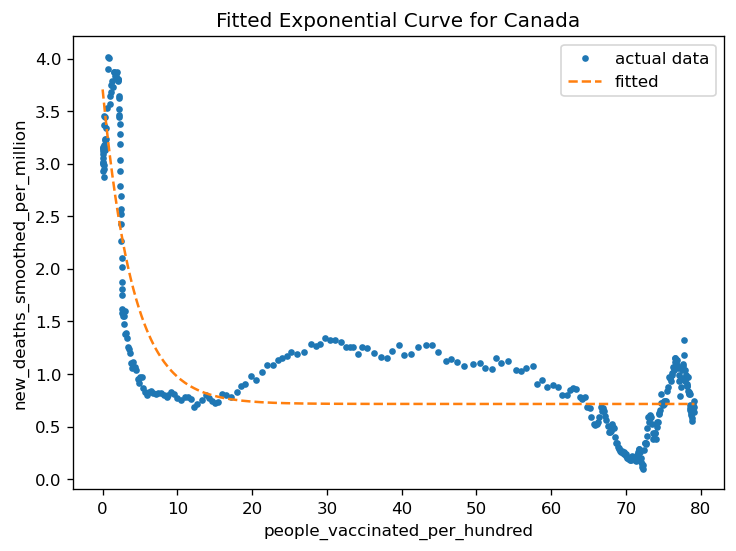

In [44]:
# perform the fit for Canada
xs = df2_can['people_vaccinated_per_hundred']
ys = df2_can['new_deaths_smoothed_per_million']
p0 = (2000, .1, 50) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(model_func, xs, ys, p0)
A, t, b = params

# determine quality of the fit
squaredDiffs = np.square(ys - model_func(xs, A, t, b))
squaredDiffsFromMean = np.square(ys - np.mean(ys))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
# inspect the parameters
print("relation can be expressed as:", f"Y = {A} * e^(-{t} * x) + {b}")

# plot the results
plt.figure(figsize=(7,5))
plt.plot(xs, ys, '.', label="actual data")
plt.plot(xs, model_func(xs, A, t, b), '--', label="fitted")
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title("Fitted Exponential Curve for Canada")
plt.legend()
plt.show()

R² = 0.9315880437434412
relation can be expressed as: Y = 8.094268000686714 * e^(-0.11148384405681927 * x) + 0.1495743097562617


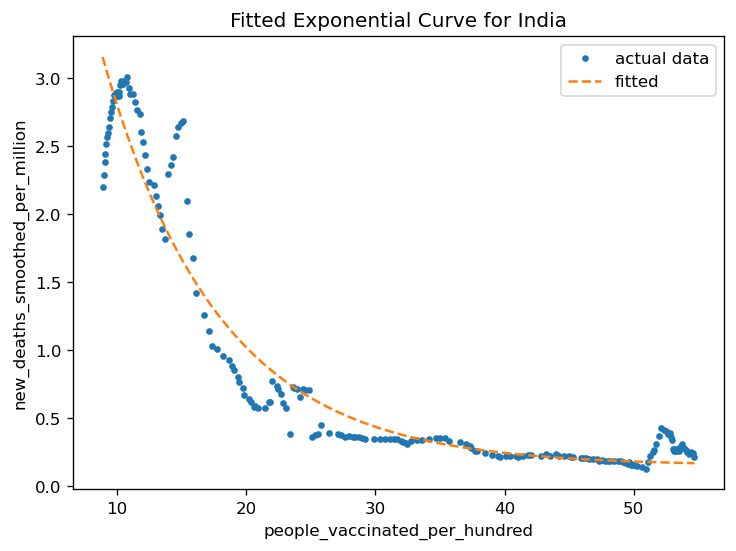

In [45]:
# perform the fit for India
#xs = df2_india['people_vaccinated_per_hundred']
xs2 = df2_india['people_vaccinated_per_hundred'][100:]
#ys = df2_india['new_deaths_smoothed_per_million']
ys2 = df2_india['new_deaths_smoothed_per_million'][100:]
p0 = (2000, .1, 50) # start with values near those we expect
params2, cv2 = scipy.optimize.curve_fit(model_func, xs2, ys2, p0)
A2, t2, b2 = params2


# determine quality of the fit
squaredDiffs = np.square(ys2 - model_func(xs2, A2, t2, b2))
squaredDiffsFromMean = np.square(ys2 - np.mean(ys2))
rSquared = 1 - np.sum(squaredDiffs) / np.sum(squaredDiffsFromMean)
print(f"R² = {rSquared}")
# inspect the parameters
print("relation can be expressed as:", f"Y = {A2} * e^(-{t2} * x) + {b2}")

# plot the results
plt.figure(figsize=(7,5))
plt.plot(xs2, ys2, '.', label="actual data")
plt.plot(xs2, model_func(xs2, A2, t2, b2), '--', label="fitted")
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title("Fitted Exponential Curve for India")
plt.legend()
plt.show()


Overall, the exponential model fits pretty well to the data for both Canada and India. One has the $R^2 = 0.79$ and the other has the $R^2 = 0.93$ which is relatively high. Thus, it's suitable to use the **exponential model in a decay way to illustrate the association of new deaths rate to the Covid-19 vaccination rate**. What that means, when number of people vaccinated increases to certain level, the number of people dead from the Covid-19 could exponentially decrease. It's definitely a good news and as an indicator suggests the health units, organizations and government to enhance the popularization of vaccines. Need to notice that we fit the exponential model on part of the Indian data, disregarding the section that vaccination rate is below 10%, because we want to temporarily exclude the increasing new deaths rate to avoid too much noise may be added to the model.  

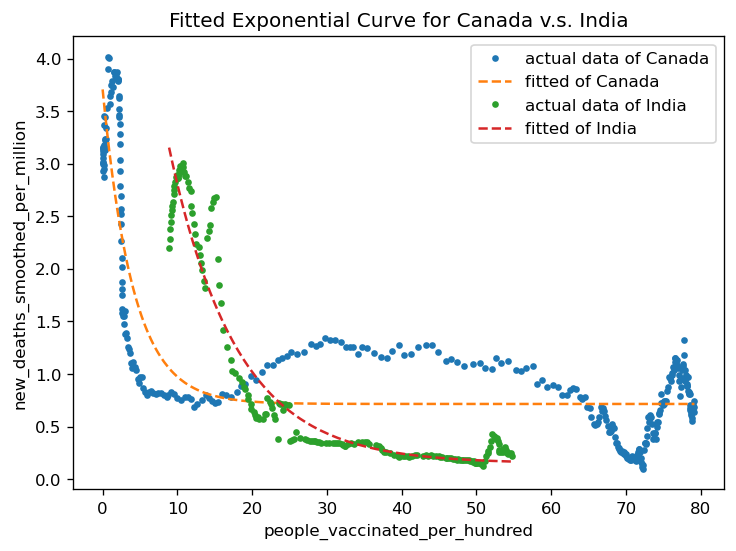

In [46]:
# Canada
xs = df2_can['people_vaccinated_per_hundred']
ys = df2_can['new_deaths_smoothed_per_million']
p0 = (2000, .1, 50) # start with values near those we expect
params, cv = scipy.optimize.curve_fit(model_func, xs, ys, p0)
A, t, b = params

# India
xs2 = df2_india['people_vaccinated_per_hundred'][100:]
ys2 = df2_india['new_deaths_smoothed_per_million'][100:]
params2, cv2 = scipy.optimize.curve_fit(model_func, xs2, ys2, p0)
A2, t2, b2 = params2

# plot the results
plt.figure(figsize=(7,5))
plt.plot(xs, ys, '.', label="actual data of Canada")
plt.plot(xs, model_func(xs, A, t, b), '--', label="fitted of Canada")
plt.plot(xs2, ys2, '.', label="actual data of India")
plt.plot(xs2, model_func(xs2, A2, t2, b2), '--', label="fitted of India")
plt.xlabel('people_vaccinated_per_hundred')
plt.ylabel('new_deaths_smoothed_per_million')
plt.title("Fitted Exponential Curve for Canada v.s. India")
plt.legend()
plt.show()

We will further compare the two countries in the below Part 5.

# Part5 Deriving Insights

### 5.1
**Preliminary explanation:**     
In section 3 and 4, we chose the country India, located in South Asia, to compare with Canada. Since they share different regions and cultural background, we thought it may be meaningful to examine their different states of coping the Covid19. Additionally, although India has huge population as a developing country, it performs surprisingly well in the increasing speed of daily vaccination in part2 EDA. Thus, we could further explore its effectiveness by comparing to the situation of highly developed country Canada.

**From section 3's observation:**   
The main observation is that the vaccination rate would keep increasing in the future on average predicted by the ARIMA time-series model, but the rate of increase is different between different countries.    

- **For Canada**, the prediction indicates that the vaccination rate would reach to 80% and 646,280.521 people would be vaccinated in the next 50 days on average (base case). However, notice the overall predicted curve is in S-shape, what that means the vaccination rate has already increased sharply during 2021-03 to 2021-07 and reaches to the carrying capacity recently. Hence, the slope of prediction curve for the next 50 days is flatter, in worst case, few new people would get vaccinated. The main reason of the situation is that Canada as a developed country prepared with high technology and talented research teams, government responded to the Covid-19 in time. The fight against the virus is almost drawing to the end.    
      
      
- **For India**, the prediction indicates that the vaccination rate would reach to 60% and 97,423,811.761 people would be vaccinated in the next 50 days on average (base case). The 60% rate is much lower to Canada's 80%. Worth to notice, the shape of the predicted curve is approximately in a linear form quite different from the one of Canada. Also, the predicted slope of the increasing vaccination rate for the next 50 days is about 45 degrees, much steeper to the slope of Canada's. In other words, India is still striving to put as much efforts as possible into Covid-19 vaccinations, in a different phase compared to Canada. Related to real life, as India has large population and large area of rural areas, it does take time to implement administration of COVID-19 vaccines gradually.    

### 5.2
**Preliminary explanation:**       
In order to further see the **effect of vaccination on our daily lives**, we choose to analyze the factor - new death rate because it is a key indicator to track the evolution of the Covid-19 pandemic. The mortality risk essentially relates to our lives, especially for families having children and older age people, as the virus could be one of the leading causes of death.     

**From section 4's observation:**   
In both cases, when vaccination rate rises, the new deaths rate first increases due to the lag effect and then starts to decrease exponentially. We focus on the decreasing part and fit an exponential model respectively to simulate for the two countries.

- **For Canada**, the exponential model indicates a sudden and steep reduction in new deaths rate when the vaccination rate only reaches to 15%. The success may be not only due to the vaccination program, but also due to some effective lock down and work-from-home policies to physically reduce the contact. The increasing implement of the vaccinations could finally keep the death rate around at 0.8 - 1 per million. Notice that the death rate falls towards to 0 at 70% vaccination rate but bounces up again later, maybe due to the new coronavirus variants in recent days.       


- **For India**, when we fit the exponential model, we disregard the rising death rate for vaccination rate $\lt$ 10% to avoid adding too much noise to the model. Since those data occupies only 20%, removing them would be acceptible. Then the model indicates a more steadily slow drop down of the death rate compared to the one of Canada's. When the vaccination rate reaches to 50%, the new deaths rate could be controlled at the 0.2 per million, which lower than the dominance under Canada.


### 5.3
**In conclusion, which one has the most effective vaccination program?**    

We would define the term "effective" from the following aspects:
1. vaccination program responds quickly to suppress the death rate     
    (i.e. make the death rate start to drop as soon as possible before it grows too large)
2. vaccination program would control the death rate as low as possible in long term
3. vaccination program ensures the death rate do not bounce back or do bounce in the smallest scale
     
From those aspects, we conclude that **India has a more effective vaccination program**.  
1. The highest death rate in India during 2021-01 climbs up to 3 per million. Then the vaccination program takes sufficient actions to suppress the death rate, starting a large drop. However, Canada makes the death rate descend until it reaches to 4 per million. Thus, it seems like that India responds to the issue in a faster manner.
      

2. As vaccination rate increases, India could control the death rate under 0.5 per million even to 0.2 per million at only vaccination rate 50%. While Canada is only capable to keep the death rate around 0.8 - 1 per million even when vaccination rate is high enough at 60% and 70%. Hence, India could better control the death rate. Since India probably started the delivery of vaccination to the public later than Canada, the vaccination rate during 2021-11 is at 50%, lower than Canada's 80%. We believe that as time pass by more people get vaccinated, India would achieve a greater success in long term.    
     
     
3. During the end of 2021-11, we could see a bigger jump in Canada's death rate maybe due to some new coronavirus variants. However, the bounce of new death rate in India is relatively smaller and still under the control of 0.5 per million. Thus, India could better prevent the pain of mortality/morbidity having less probability in coming back severely again.     
     
     
4. Though one may argue that Canada has a faster and sharper decrease of new death rate at first, we think the success cannot be all accredited to its vaccination program. In addition, Canadian government pushed hard on the lock-down policies and work-from-home rules during that period of time. It could be highly efficient for small population. Also, after the sharp decrease, Canada doesn't perform as good as India.

Overall, admittedly India is a developing country with the second highest population and number of Covid-19 cases. If people give India enough time, India vaccination program could perform better in sustainably reducing morbidity and mortality from COVID-19. In addition, India also has their own manufactures and companies to supply the vaccines so that India is also resistant to any future challenges. Finally, the effective program would guarantee broad immunological protection, especially for the most vulnerable populations.